In [7]:
# 3 cavity modes, 3lvl, multiAtom

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
from qutip import *
import time

In [8]:
# Modeling multiple cavity modes

cav_modes = 1 # num of cav modes
cav_max = 3 # this means can have 0, 1 or 2 photons
phot_init = 0 
#p_init = 0
#r_init = 0

# generic initial state
cav0 = basis(cav_max, n = phot_init)
p0 = basis(cav_max, n = phot_init)
r0 = basis(cav_max, n = phot_init)
#
cav = tensor([cav0 for i in range(cav_modes)])
exc = tensor([p0 for i in range(cav_modes)]) 
ryd = tensor([r0 for i in range(cav_modes)])
# |phot_n, p_n, r_ n > for n <= cav_modes
psi0 = tensor([cav, exc, ryd])

# collective bosonic a, p, r state destruction_ops
# list representation of operators to be tensored later
Id_cav = [qeye(cav_max) for i in range(cav_modes)]
Id_p = Id_cav
Id_r = Id_cav


a = ['' for i in range(cav_modes)] # to be populated by a0, a1, a2
p = ['' for i in range(cav_modes)] # to be populated by p0, p1, p2
r = ['' for i in range(cav_modes)] # to be populated by r0, r1, r2

# populate a
for i in range(cav_modes):
    temp = [qeye(cav_max) for j in range(cav_modes)]
    temp[i] = destroy(cav_max)
    temp = temp + Id_p + Id_r
    a[i] = tensor(temp)
    
# populate p
temp = []
for i in range(cav_modes):
    temp = [qeye(cav_max) for j in range(cav_modes)]
    temp[i] = destroy(cav_max)
    temp = Id_cav + temp + Id_r
    p[i] = tensor(temp)

# populate r  
temp = []
for i in range(cav_modes):
    temp = [qeye(cav_max) for j in range(cav_modes)]
    temp[i] = destroy(cav_max)
    r[i] = tensor(Id_cav + Id_p + temp)   

# cav-p exchange, p-r exchange, drive
pexchange = [(p[i].dag()*a[i] + a[i].dag()*p[i]) for i in range(cav_modes)]
rexchange = [(r[i].dag()*p[i] + p[i].dag()*r[i]) for i in range(cav_modes)]

In [9]:
# parameters placeholders
c = [1, 1, 1]
delta_c = [1, 1, 1]
delta_e = 1
delta_2 = 1
G = [1, 1, 1] 
omega = 1
prb = 0.3 

# decay params
kappa = 1.4
gamma = 6
gamma_r = 0.1

# collapse operators
# NOTE: each mode gets its own collapse operator 
# but the decay param is identical for all modes
c_phot = [np.sqrt(kappa)*a_k for a_k in a]
c_p = [np.sqrt(gamma)*p_k for p_k in p]
c_r =  [np.sqrt(gamma_r)*r_k for r_k in r]

collapse = c_phot + c_p + c_r

In [10]:
# Some useful functions

# qutip implements 
# coherence_function_g2(H, state0, times, c_ops, a_ops)

# calculate g2 for dest and rho via H
# rho: q-state
# dest: destruction op
# times: np.linspace of times
# c: list of collapse operators
def g2(rho, H, dest, times, c=collapse, options=Options(tidy=False)):
    rho_m1 = dest * rho * dest.dag()
    norm = np.trace(rho_m1)
    rho_m1 = dest * (rho/norm) * dest.dag()
    rho_m1_t = mesolve(H, rho_m1, times, c, [dest.dag()*dest], options=options)
    
    num = rho_m1_t.expect[0] * norm
    den = np.power(np.trace(dest.dag()*dest*rho), 2)
    
    return num/den

# calculate H_eff given params
def H_eff(c, delta_c, delta_e, delta_2, G, omega, prb):
    # Effective Hamiltonian
    
    tot_drive = sum([c_k*a_k for c_k, a_k in zip(c, a)])
    tot_drive = prb*(tot_drive + tot_drive.dag())
    
    tot_phot = sum([coeff*op.dag()*op for coeff, op in zip(delta_c,a)])
    tot_p = delta_e * sum([op.dag()*op for op in p])
    tot_r = delta_2 * sum([op.dag()*op for op in r])
    
    tot_pexchange = sum([coeff*op for coeff, op in zip(G,pexchange)])
    tot_rexchange = omega * sum(rexchange)

    H_eff = tot_drive + tot_phot + tot_p + tot_r + tot_pexchange + tot_rexchange
    
    return H_eff

**Tests for Multi Cavity modes**

(0.9972575003135817+0j)


/home/dawit/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'mode=1 0 0| g=0 | $\\Omega$ =0 | $\\kappa$=1.4 | $\\Gamma_R$=0.1 | $\\Gamma_P$=6 | PrbPwr=0.03')

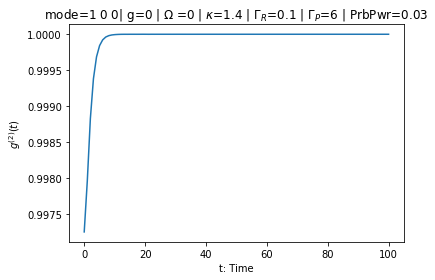

In [11]:
# Test [1]: only prb and single mode for g2

c = [1, 0, 0]
delta_c = [0, 0, 0]
delta_e = 0
delta_2 = 0
G = [0, 0, 0] 
omega = 0
prb = 0.03

# get Hamiltonian and steady state
# H = prb*(a + a.dag)
H = H_eff(c, delta_c, delta_e, delta_2, G, omega, prb)

rho_ss = steadystate(H, collapse, method='direct')

times = np.linspace(0, 100, 100)

# get g2(times) for a[0] 
g2_t = g2(rho_ss, H, a[0], times)
# g2_t = coherence_function_g2(H, rho_ss, times, collapse, a[0])[0] # return normalized g2
print(g2_t[0])

# plot g2_t
fig=plt.figure()
plt.plot(times, g2_t)
plt.xlabel('t: Time')
plt.ylabel('$g^{(2)}(t)$')
plt.title('mode='+ " ".join(str(x) for x in c) + '| g='+str(G[0]) +  ' | $\Omega$ =' + str(omega) + ' | $\kappa$=' + str(kappa)  + ' | $\Gamma_R$=' + str(gamma_r) +' | $\Gamma_P$=' + str(gamma) + ' | PrbPwr=' + str(prb))

/home/dawit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5, 1.0, '   mode=1 0 0| g=5 | $\\Omega$ =0 | $\\kappa$=1.4 | $\\Gamma_R$=0.1 | $\\Gamma_P$=6 | PrbPwr=0.03')

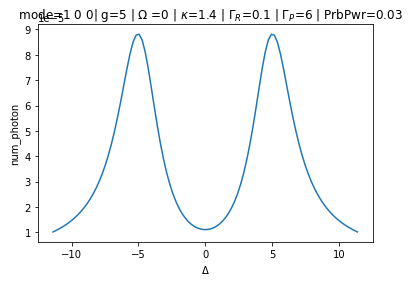

In [12]:
# Test [2]: VRS spectrum for a[0] mode

c = [1, 0, 0] # pumping only a[0] photons
G = [5, 0, 0] # coupling a[0] and p[0]
omega = 0 # no r-exchange
prb = 0.03

npts = 100
nphot = np.empty(npts)
deltas = np.linspace(-2*np.sqrt(G[0]**2 + omega**2) - kappa, 2*np.sqrt(G[0]**2 + omega**2) + kappa, npts)

for i, delta in enumerate(deltas):
    delta_c = [delta, 0, 0]
    delta_e = delta
    delta_2 = delta
    
    # get Hamiltonian and steady state
    
    # H = prb*drive + G[0](p.dag[0]*a[0] + a.dag[0]p[0]) + delta*(N_phot[0] + N_p[0] + N_r[0])
    H = H_eff(c, delta_c, delta_e, delta_2, G, omega, prb) 
        
    rho_ss = steadystate(H, collapse , method='eigen')
    nphot[i] = np.trace(a[0].dag()*a[0]*rho_ss)
    # expectation of a[0] operator for each delta value 

fig = plt.figure()
plt.plot(deltas, nphot)
plt.xlabel('$\Delta$')
plt.ylabel('num_photon')
plt.title('   mode='+ " ".join(str(x) for x in c) + '| g='+str(G[0]) +  ' | $\Omega$ =' + str(omega) + ' | $\kappa$=' + str(kappa)  + ' | $\Gamma_R$=' + str(gamma_r) +' | $\Gamma_P$=' + str(gamma) + ' | PrbPwr=' + str(prb))

In [13]:
# figure out which quantity is the complex warning coming from
#
# TODO: make H_eff quicker ??? 
# 
# H_eff(...) re-computes unecessary ops like 
# drive, tot_rexchange, tot_p, tot_r
#
# use python time library to see the slow parts

/home/dawit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5, 1.0, '   mode=1 0 0| g=5 | $\\Omega$ =2 | $\\kappa$=1.4 | $\\Gamma_R$=0.1 | $\\Gamma_P$=6 | PrbPwr=0.03')

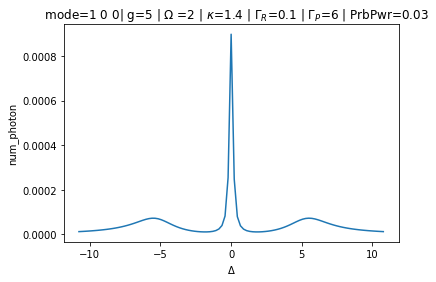

In [14]:
# Test [3]: EIT spectrum for a[0]

c = [1, 0, 0] # pumping only a[0] photons
G = [5, 0, 0] # coupling a[0] and p[0]
omega = 2 # r-exchange
prb = 0.03

npts = 50
nphot = np.empty(2*npts)
deltas = np.linspace(0, 2*np.sqrt(G[0]**2 + omega**2), npts)
deltas = np.concatenate([np.linspace(-2*np.sqrt(G[0]**2 + omega**2), 0, npts, endpoint=False), deltas])

for i, delta in enumerate(deltas):
    delta_c = [delta, 0, 0]
    delta_e = delta
    delta_2 = delta
    
    # get Hamiltonian and steady state
    
    # H = prb*drive + G[0](p.dag[0]*a[0] + a.dag[0]p[0]) + delta*(N_phot[0] + N_p[0] + N_r[0])
    H = H_eff(c, delta_c, delta_e, delta_2, G, omega, prb) 
        
    rho_ss = steadystate(H, collapse , method='eigen')
    nphot[i] = np.trace(a[0].dag()*a[0]*rho_ss)
    # expectation of a[0] operator for each delta value 

fig = plt.figure()
plt.plot(deltas, nphot)
plt.xlabel('$\Delta$')
plt.ylabel('num_photon')
plt.title('   mode='+ " ".join(str(x) for x in c) + '| g='+str(G[0]) +  ' | $\Omega$ =' + str(omega) + ' | $\kappa$=' + str(kappa)  + ' | $\Gamma_R$=' + str(gamma_r) +' | $\Gamma_P$=' + str(gamma) + ' | PrbPwr=' + str(prb))

(27, 27)
(0.040915820854830066+0j)


/home/dawit/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'DARK|mode=1 0 0|U=10| g=5 | $\\Omega$ =2 | $\\kappa$=1.4 | $\\Gamma_R$=0.1 | $\\Gamma_P$=6 | PrbPwr=0.03')

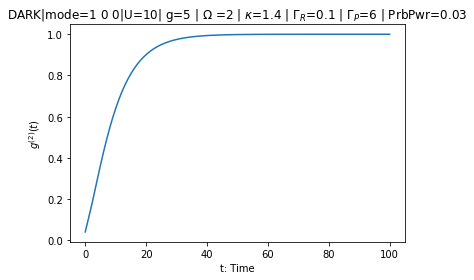

In [17]:
# Test [4]: single mode interaction for r[0]; look for g2(0) supresssion @ dark mode

# I am going to put in the interaction term by hand 
# because interaction is second order Hamiltonian

# interaction = U * 1/2 *r.dag()*r.dag()*r*r

# params
c = [1, 0, 0]
delta = 0 # @ dark mode peak
delta_c = [delta, 0, 0] 
delta_e = delta
delta_2 = delta
G = [5, 0, 0] 
omega = 2
U = 10
prb = 0.03

# Hamiltonian
interaction = U * 1/2 * r[0].dag()*r[0].dag()*r[0]*r[0]
H = H_eff(c, delta_c, delta_e, delta_2, G, omega, prb) + interaction

rho_ss = steadystate(H, collapse, method='direct')
times = np.linspace(0, 100, 100)

# get g2(times) for a[0] 
g2_t = g2(rho_ss, H, a[0], times)
# g2_t = coherence_function_g2(H, rho_ss, times, collapse, a[0])[0] # return normalized g2

# should be: 0.04 ish
print(g2_t[0])

# plot g2_t
fig=plt.figure()
plt.plot(times, g2_t)
plt.xlabel('t: Time')
plt.ylabel('$g^{(2)}(t)$')
plt.title('DARK' + '|mode='+ " ".join(str(x) for x in c) + '|U='+str(U) + '| g='+str(G[0]) +  ' | $\Omega$ =' + str(omega) + ' | $\kappa$=' + str(kappa)  + ' | $\Gamma_R$=' + str(gamma_r) +' | $\Gamma_P$=' + str(gamma) + ' | PrbPwr=' + str(prb))

(0.9915070393862359+0j)


/home/dawit/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'BRIGHT|mode=1 0 0|U=10| g=5 | $\\Omega$ =2 | $\\kappa$=1.4 | $\\Gamma_R$=0.1 | $\\Gamma_P$=6 | PrbPwr=0.001')

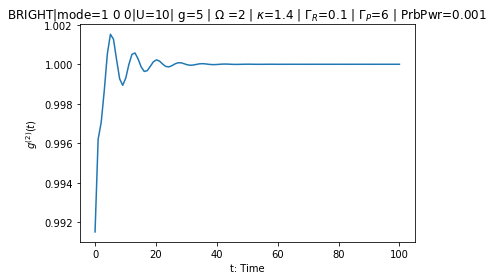

In [16]:
# Test [5]: single mode interaction for r[0]; look for less g2(0) supresssion @ bright mode 

# I am going to put in the interaction term by hand 
# because interaction is second order Hamiltonian

# interaction = U * 1/2 *r.dag()*r.dag()*r*r

# params
c = [1, 0, 0]
G = [5, 0, 0] 
omega = 2
delta = np.sqrt(G[0]**2 + omega**2)  # @ bright mode peak
delta_c = [delta, 0, 0]
delta_e = delta
delta_2 = delta
U = 10
prb = 0.001

# Hamiltonian
interaction = U * 1/2 * r[0].dag()*r[0].dag()*r[0]*r[0]
H = H_eff(c, delta_c, delta_e, delta_2, G, omega, prb) + interaction

rho_ss = steadystate(H, collapse, method='direct')
times = np.linspace(0, 100, 100)

# get g2(times) for a[0] 
g2_t = g2(rho_ss, H, a[0], times)
# g2_t = coherence_function_g2(H, rho_ss, times, collapse, a[0])[0] # return normalized g2

# should be: 0.999 ish
print(g2_t[0])

# plot g2_t
fig=plt.figure()
plt.plot(times, g2_t)
plt.xlabel('t: Time')
plt.ylabel('$g^{(2)}(t)$')
plt.title('BRIGHT' + '|mode='+ " ".join(str(x) for x in c) + '|U='+str(U) + '| g='+str(G[0]) +  ' | $\Omega$ =' + str(omega) + ' | $\kappa$=' + str(kappa)  + ' | $\Gamma_R$=' + str(gamma_r) +' | $\Gamma_P$=' + str(gamma) + ' | PrbPwr=' + str(prb))